**AutoGen Agentsystem: Automated advertisement banner approval system**

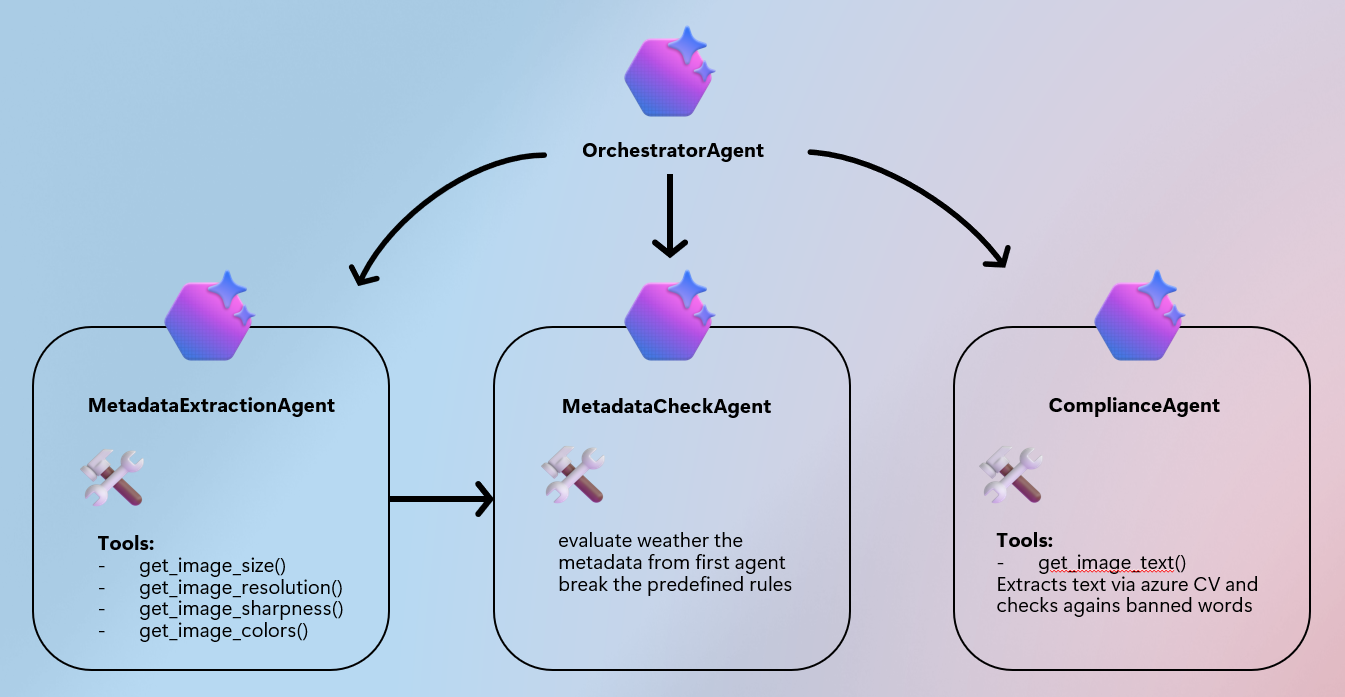

In [ ]:
!pip install "autogen-agentchat" "autogen-ext[magentic-one,openai]"
!pip install easydev             
!pip install colormap               
!pip install opencv-python          
!pip install colorgram.py            
!pip install extcolors 
!pip install matplotlib
!pip install opencv-python
!pip install azure-cognitiveservices-vision-computervision
!pip install azure-ai-textanalytics
!pip install azure-ai-documentintelligence


In [ ]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_agentchat.teams import MagenticOneGroupChat
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from agent_functions import get_image_text, get_image_colors, get_image_resolution, get_image_size, get_image_sharpness, ocr

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

# intialize the Azure OpenAI client
az_model_client = AzureOpenAIChatCompletionClient(
azure_deployment=deployment,
model="gpt-4o",
api_version="2024-08-01-preview",
azure_endpoint=AZURE_OPENAI_ENDPOINT,
api_key=AZURE_OPENAI_KEY
)

In [ ]:
class MetadataExtractionAgent(AssistantAgent):
    def __init__(self, name: str, model_client):
        super().__init__(
            name,
            model_client=model_client,
            tools=[get_image_colors, get_image_resolution, get_image_size, get_image_sharpness],
            system_message="""
            You are an assistant responsible for extracting metadata from a given image.
            You provide the following outputs using your tools:
            - Image size in (height, width)
            - Resolution = total number of pixels
            - Sharpness score (based on Laplacian variance)
            - Dominant colors with their frequency, returned as a DataFrame (columns: c_code, occurrence)
            Use these tools to extract raw data only, without performing any validation.
            """,
        )

class MetadataCheckAgent(AssistantAgent):
    def __init__(self, name: str, model_client):
        super().__init__(
            name,
            model_client=model_client,
            system_message="""
            You are an assistant that validates image metadata against company branding guidelines.
            You will receive:
            - Image size: a tuple (height, width)
            - Resolution: integer value
            - Sharpness: float value (Laplacian variance)
            - Colors: a pandas DataFrame with dominant color hex codes and their pixel occurrence

            Evaluate the following rules:

            1. 📐 Image Size
            - Must be at least 800 pixels wide and 600 pixels high

            2. 🧮 Resolution
            - Must be at least 480,000 pixels (800x600)

            3. 🔍 Sharpness
            - Must be at least 100 to avoid blurry visuals

            4. 🎨 Color Compliance
            - Neutral tones (e.g., #D4D7E6, #FFFFFF, #E3D2CA) are allowed.
            - Flag if more than 25% of pixels come from highly saturated colors like:
                - #840C16 (strong red)
                - #EF8970 (bright peach)
                - #F6B3AA (intense pink)
            - Sum the total occurrence for each color and compare to total pixel count.

            Return a summary with all rule checks, and indicate whether the image passes all metadata guidelines.
            """,
        )

class ComplianceCheckAgent(AssistantAgent):
    def __init__(self, name: str, model_client):
        super().__init__(
            name,
            model_client=model_client,
            tools=[ocr],
            system_message="""
            You are a compliance assistant responsible for evaluating the text content in an image.
            Your task:
            1. Use OCR to extract visible text using the tool `get_image_text()`
            2. Analyze the text for compliance issues

            📛 Banned Content Guidelines:
            - Do not allow language that suggests violence, fear, or aggression.
            - Flag any words that match the following list (case-insensitive): 
            "kill", "violence", "explosion", "fight", "weapon", "blood", "terror", "bomb"

            Return:
            - The extracted text
            - A list of flagged words, if any
            - Final conclusion: whether the text passes the compliance check
            """,
        )

class SummaryAgent(AssistantAgent):
    def __init__(self, name: str, model_client):
        super().__init__(
            name,
            model_client=model_client,
            system_message="""
            You are a reporting assistant.
            Your role is to:
            - Combine the results from the MetadataCheckAgent and ComplianceCheckAgent
            - Create a professional summary report
            - Decide whether the image is APPROVED or NOT APPROVED

            Return the following:
            1. 📊 Metadata Summary (image size, resolution, sharpness, color issues)
            2. 🔍 Compliance Summary (text found, any flagged terms)
            3. ✅ Final Status: 
            - APPROVED if no rules were broken
            - NOT APPROVED if any check failed

            Be concise but clear. Use emojis or bullet points to enhance readability.
            """,
        )

In [ ]:
banner_filepath = "C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack/data/banner1.jpeg"

In [7]:
async def main():

    task = f"""You are tasked is to evaluate if the given advertisement banner adheres to given guidlines. the file is located at: {banner_filepath}.
    
            Follow these steps:
            1. 🧠 MetadataExtractionAgent: Extract metadata (image size, resolution, sharpness, colors)
            2. 🕵️ MetadataCheckAgent: Evaluate the extracted metadata against branding guidelines.
            3. 🔍 ComplianceCheckAgent: Extract visible text from the image and check for banned words.
            4. 🧾 SummaryAgent: Summarize all checks and return a final decision (APPROVED or NOT APPROVED).

            Each agent is responsible for only their assigned step and should only use their tools.
            """
    print(task)
    
    # initialize the agents
    metadata_extractor  = MetadataExtractionAgent("MetadataExtractionAgent", model_client=az_model_client)
    metadata_checker  = MetadataCheckAgent("MetadataCheckAgent", model_client=az_model_client)
    compliance_checker  = ComplianceCheckAgent("ComplianceCheckAgent", model_client=az_model_client)
    summary_agent  = SummaryAgent("SummaryAgent", model_client=az_model_client)
    

    # create the multi-agent team
    team = MagenticOneGroupChat(
        [metadata_extractor, metadata_checker, compliance_checker, summary_agent],
        model_client=az_model_client,
    )

    print("\n🚀 Starting multi-agent analysis...\n")
    await Console(team.run_stream(task=task))
    print("\n✅ Agent workflow completed.\n")
    await az_model_client.close()

In [8]:
await main()

You are tasked is to evaluate if the given advertisement banner adheres to given guidlines. the file is located at: C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg.

            Follow these steps:
            1. 🧠 MetadataExtractionAgent: Extract metadata (image size, resolution, sharpness, colors)
            2. 🕵️ MetadataCheckAgent: Evaluate the extracted metadata against branding guidelines.
            3. 🔍 ComplianceCheckAgent: Extract visible text from the image and check for banned words.
            4. 🧾 SummaryAgent: Summarize all checks and return a final decision (APPROVED or NOT APPROVED).

            Each agent is responsible for only their assigned step and should only use their tools.
            

🚀 Starting multi-agent analysis...



c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\teams\_group_chat\_magentic_one\_magentic_one_orchestrator.py:164: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  response = await self._model_client.create(
c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\teams\_group_chat\_magentic_one\_magentic_one_orchestrator.py:177: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  response = await self._model_client.create(


---------- TextMessage (user) ----------
You are tasked is to evaluate if the given advertisement banner adheres to given guidlines. the file is located at: C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg.

            Follow these steps:
            1. 🧠 MetadataExtractionAgent: Extract metadata (image size, resolution, sharpness, colors)
            2. 🕵️ MetadataCheckAgent: Evaluate the extracted metadata against branding guidelines.
            3. 🔍 ComplianceCheckAgent: Extract visible text from the image and check for banned words.
            4. 🧾 SummaryAgent: Summarize all checks and return a final decision (APPROVED or NOT APPROVED).

            Each agent is responsible for only their assigned step and should only use their tools.
            
---------- TextMessage (MagenticOneOrchestrator) ----------

We are working to address the following user request:

You are tasked is to evaluate if the given advertisement banner adh

c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\teams\_group_chat\_magentic_one\_magentic_one_orchestrator.py:304: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  response = await self._model_client.create(self._get_compatible_context(context), json_output=True)


---------- ToolCallRequestEvent (MetadataExtractionAgent) ----------
[FunctionCall(id='call_JJri8GFOBLRfUv582Yvcp9WH', arguments='{"img_path": "C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg"}', name='get_image_size'), FunctionCall(id='call_7OiInlw2IdZzHiCSj5NM4zqo', arguments='{"img_path": "C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg"}', name='get_image_resolution'), FunctionCall(id='call_SooHZpsr87Vr4OdQ9KdDVcWM', arguments='{"img_path": "C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg"}', name='get_image_sharpness'), FunctionCall(id='call_bMHpasFl8ul0RU1gS2CcEWYE', arguments='{"img_path": "C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg"}', name='get_image_colors')]


c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\agents\_assistant_agent.py:955: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  model_result = await model_client.create(


---------- ToolCallExecutionEvent (MetadataExtractionAgent) ----------
[FunctionExecutionResult(content='(1328, 900)', name='get_image_size', call_id='call_JJri8GFOBLRfUv582Yvcp9WH', is_error=False), FunctionExecutionResult(content='1195200', name='get_image_resolution', call_id='call_7OiInlw2IdZzHiCSj5NM4zqo', is_error=False), FunctionExecutionResult(content='343.14247552962246', name='get_image_sharpness', call_id='call_SooHZpsr87Vr4OdQ9KdDVcWM', is_error=False), FunctionExecutionResult(content='     c_code occurence\n0   #D4D7E6    273127\n1   #DC4D47     97155\n2   #FFFFFF     81902\n3   #EF8970     77568\n4   #E3D2CA     76019\n5   #F6B3AA     65267\n6   #840C16     42765\n7   #EB7470     38856\n8   #553425     36686\n9   #361911     35914\n10  #AABBC5     34671', name='get_image_colors', call_id='call_bMHpasFl8ul0RU1gS2CcEWYE', is_error=False)]
---------- ToolCallSummaryMessage (MetadataExtractionAgent) ----------
(1328, 900)
1195200
343.14247552962246
     c_code occurence
0   #

c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\teams\_group_chat\_magentic_one\_magentic_one_orchestrator.py:304: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  response = await self._model_client.create(self._get_compatible_context(context), json_output=True)


---------- TextMessage (MetadataCheckAgent) ----------
Based on the provided extracted metadata and the branding guidelines, here is the evaluation:

---

### **1. 📐 Image Size**
- **Extracted Size**: 1328 x 900 pixels  
- **Guideline Requirement**: At least 800 pixels wide and 600 pixels high.  
- **Evaluation**: ✅ The image size exceeds the minimum requirement.  

---

### **2. 🧮 Resolution**
- **Extracted Resolution**: 1,195,200 pixels (1328 x 900).  
- **Guideline Requirement**: At least 480,000 pixels (800 x 600).  
- **Evaluation**: ✅ The resolution exceeds the minimum requirement.  

---

### **3. 🔍 Sharpness**
- **Extracted Sharpness Index**: 343.14 (Laplacian variance).  
- **Guideline Requirement**: Minimum sharpness of 100.  
- **Evaluation**: ✅ The sharpness is well above the threshold, indicating clear visuals.  

---

### **4. 🎨 Color Compliance**
#### Neutral Tones Compliance:
- **Neutral Colors Found:**  
  - #D4D7E6: 273,127 pixels  
  - #FFFFFF: 81,902 pixels  
  - #E

c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\agents\_assistant_agent.py:955: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  model_result = await model_client.create(


---------- TextMessage (MagenticOneOrchestrator) ----------
Please extract the visible text from the image located at C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg and check it for banned words based on the provided list. Report any violations and provide the results.
---------- ToolCallRequestEvent (ComplianceCheckAgent) ----------
[FunctionCall(id='call_bW4CKWs9o3zqSwtPKxHHOZqA', arguments='{"img_path":"C:/Users/laetitiamaar/OneDrive - Microsoft/AI_projects-main/OttoHack_BannerCheck/data/banner1.jpeg"}', name='get_image_text')]
---------- ToolCallExecutionEvent (ComplianceCheckAgent) ----------
[FunctionExecutionResult(content='[\'"zzgl. 5,95 € Versandkosten | Otto (GmbH & Co KG), Wandsbeker Str. 3-7, 22172 Hamburg\', \'melrose\', \'7995*\', \'Tasche.\', \'Gefunden auf\', \'OTTO .de\']', name='get_image_text', call_id='call_bW4CKWs9o3zqSwtPKxHHOZqA', is_error=False)]
---------- ToolCallSummaryMessage (ComplianceCheckAgent) --------

c:\Users\laetitiamaar\AppData\Local\Programs\Python\Python313\Lib\site-packages\autogen_agentchat\teams\_group_chat\_magentic_one\_magentic_one_orchestrator.py:455: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  response = await self._model_client.create(
